Name: Antony Krymski

Username: agk-123

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Data

In [10]:
df = pd.read_hdf('data/data.h5', 'SPY')
df.index = pd.to_datetime(df.index, unit='s')
df = np.rint(df * 100).astype(np.int32)
df

,Open,High,Low,Close,Volume
Date,,,,,
1998-07-01 09:32:00,738100,738100,737700,737700,25760000
1998-07-01 09:33:00,738400,738600,738100,738100,2440000
1998-07-01 09:34:00,738100,738600,738100,738600,250000
1998-07-01 09:35:00,738300,738300,737900,737900,90000
1998-07-01 09:36:00,738300,738300,738100,738100,300000
...,...,...,...,...,...
2023-03-31 15:55:00,4087600,4093400,4087400,4091800,156284100
2023-03-31 15:56:00,4091900,4093400,4090500,4093200,70754400
2023-03-31 15:57:00,4093300,4094100,4092400,4094000,80362600


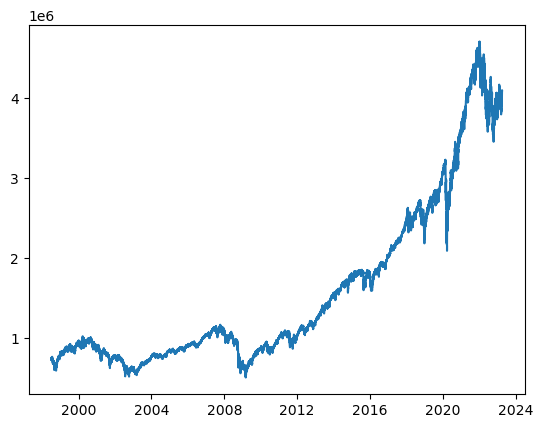

In [11]:
plt.plot(df['Close'])

# Pre-processing

(2399384, 1)


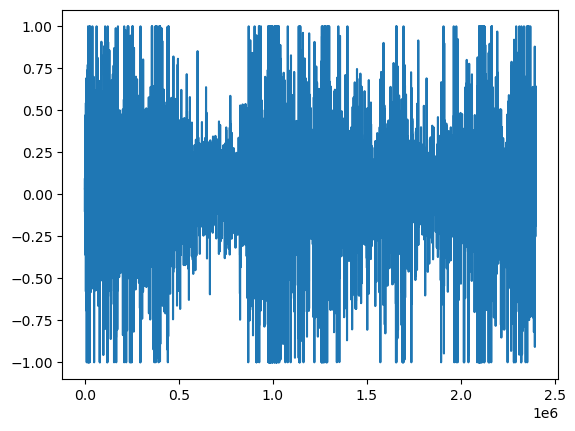

In [12]:
# select features
X = df[['Close']].values 
X = X.astype(np.float32)

# make data stationary using log returns
X = np.log(X)
X = np.diff(X, axis=0)

# remove 0.01% outliers
outliers = np.quantile(np.abs(X), 0.9999)
X = np.clip(X, -outliers, outliers)

# scale
X = X / np.max(np.abs(X))

assert(np.isnan(X).any() == False)

plt.plot(X[:, 0])
print(X.shape)

In [13]:
timesteps = 128
features = 1
input_shape = (timesteps, features)
code_size = 32
batch_size = 16
train_index = int(0.7 * len(X))

In [14]:
x_train = X[:train_index]
x_test = X[train_index:]

x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

y_train = x_train[timesteps::timesteps]
y_test = x_test[timesteps::timesteps]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(x_train.shape[0] == y_train.shape[0])

(13121, 128, 1) (5623, 128, 1)
(102, 128, 1) (43, 128, 1)


AssertionError: 

# Data Generation

In [7]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            # flipping but not well (only do if non stationary data)
            # y_negative = np.max(y_positive) + np.min(y_positive) - y_positive
            
            # make y_negative normal distribution from same range as y_positive
            # y_negative = np.random.lognormal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0]) - 1.
            # y_negative = np.clip(y_negative, -1.0, 1.0)
            # y_negative = np.expand_dims(y_negative, -1)

            # y_negative = self.data[np.random.choice(indexes)]
            y_negative = y_positive * -1.

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [8]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

819
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

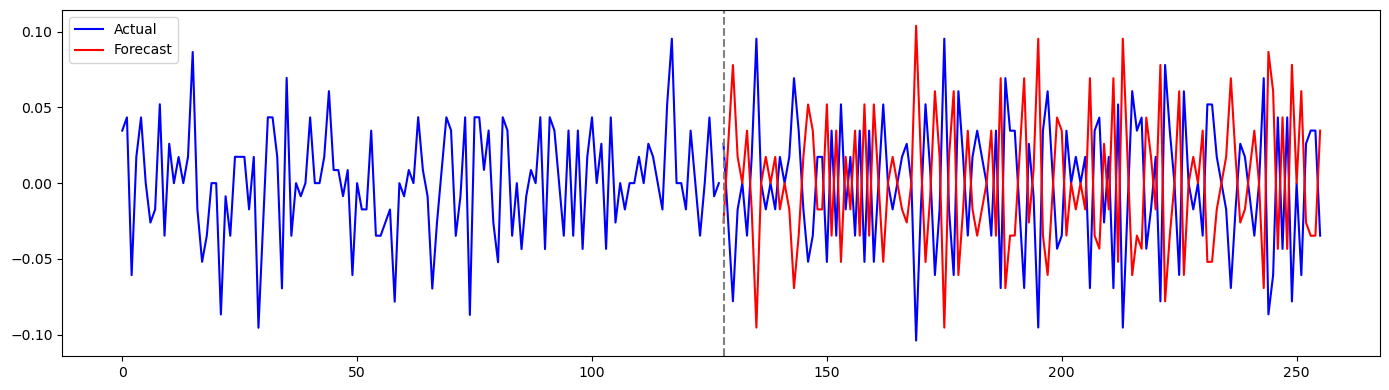

In [9]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(x[0, :, 0], y[0, :, 0], y[1, :, 0])

# Model Architecture

In [11]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(input)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 64)           12352     
                                                                 
 encoder_embedding (Dense)   (None, 128, 32)           2080      
                                                                 
Total params: 14,688
Trainable params: 14,688
Non-trainable params: 0
_________________________________________________________________


In [12]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, name="context")(input)
    # x = LSTM(code_size, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 32)]         0         
                                                                 
 context (LSTM)              (None, 128, 32)           8320      
                                                                 
 preds (Dense)               (None, 128, 32)           1056      
                                                                 
Total params: 9,376
Trainable params: 9,376
Non-trainable params: 0
_________________________________________________________________


In [162]:
# test classification naively 
# x_input = Input(input_shape, name='x_input')
# y_input = Input(input_shape, name='y_input')

# x = keras.layers.Concatenate(axis=1)([x_input, y_input])
# # x = y_input
# x = Conv1D(32, 3, activation='relu', padding='same')(x)
# x = LSTM(32, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=[x_input, y_input], outputs=x, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 y_input (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 concatenate_15 (Concatenate)   (None, 256, 1)       0           ['x_input[0][0]',                
                                                                  'y_input[0][0]']                
                                                                                                  
 conv1d_30 (Conv1D)             (None, 256, 64)      256         ['concatenate_15[0][0]']       

In [13]:
x_input = Input(input_shape)
encoded = encoder(x_input)
y_pred = context(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

dot_product = K.sum(y_encoded * y_pred, axis=-1)
# dot_product = K.mean(y_encoded * y_pred, axis=-1)
dot_product = K.sum(dot_product, axis=-1, keepdims=True)  # along the temporal dimension

dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 128, 32)      14688       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 context (Functional)           (None, 128, 32)      9376        ['encoder[0][0]']              

In [14]:
batch_size = 64
epochs = 10

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [15]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/10
204/204 [==============================] - 9s 36ms/step - loss: 0.6904 - binary_accuracy: 0.5150 - val_loss: 0.6911 - val_binary_accuracy: 0.5553
Epoch 2/10
204/204 [==============================] - 7s 34ms/step - loss: 0.6794 - binary_accuracy: 0.5490 - val_loss: 0.6820 - val_binary_accuracy: 0.6027
Epoch 3/10
204/204 [==============================] - 7s 34ms/step - loss: 0.6752 - binary_accuracy: 0.5611 - val_loss: 0.6811 - val_binary_accuracy: 0.5625
Epoch 4/10
204/204 [==============================] - 7s 35ms/step - loss: 0.6727 - binary_accuracy: 0.5631 - val_loss: 0.6792 - val_binary_accuracy: 0.6255
Epoch 5/10
204/204 [==============================] - 7s 35ms/step - loss: 0.6670 - binary_accuracy: 0.5786 - val_loss: 0.6692 - val_binary_accuracy: 0.5855
Epoch 6/10
204/204 [==============================] - 7s 35ms/step - loss: 0.6669 - binary_accuracy: 0.5802 - val_loss: 0.6625 - val_binary_accuracy: 0.6318
Epoch 7/10
204/204 [==============================] - 7s 3

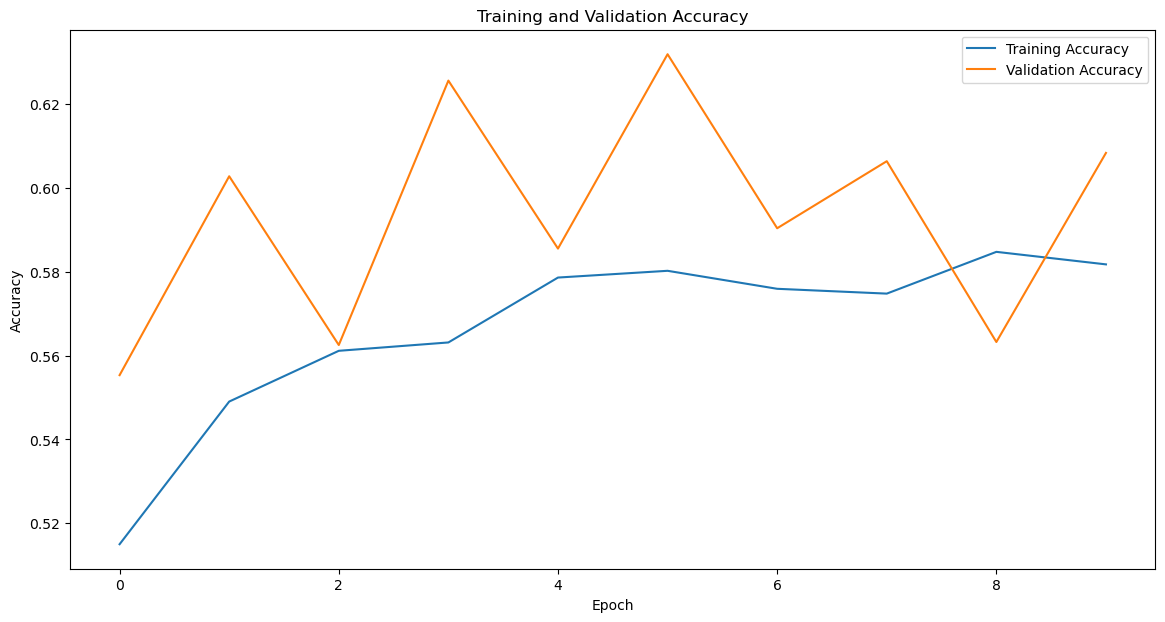

In [16]:
plot_training(history)

In [18]:
encoder.save('encoder.h5', include_optimizer=False)

In [75]:
# encoder = load_model('encoder.h5', compile=True)

# Xh = np.empty((len(X) - timesteps, code_size))
# Yh = np.empty((len(X) - timesteps))

# batch_size = 1000

# indexes = np.arange(len(X) - timesteps)
# batches = len(indexes) // batch_size

# for batch in batches:
#     indexes = indexes[batch*batch_size//2:(batch+1)*batch_size//2]
#     batch = []
#     for i in indexes:

# for i in range(0, len(X) - timesteps, batch_size):
#     batch = []
#     for j in range(i, i+batch_size):
#         batch.append(X[j:j+timesteps])

#     # batch = np.expand_dims(X[i:i+timesteps], axis=0)
#     embeddings = encoder.predict(np.array(batch))
#     print(embeddings.shape)
#     for j in range(batch_size):
#         Xh[i] =  embeddings[j]
#         Yh[i] = X[i+timesteps]

# print(Xh.shape, Yh.shape)

1/1 [==============================] - 0s 91ms/step
(16, 128, 32)


ValueError: could not broadcast input array from shape (128,32) into shape (32,)

# Downstream Task

In [64]:
for i in range(len(x_train)-1):
    y_train[i] = np.sum(x_train[i+1, :, 0])
for i in range(len(x_test)-1):
    y_test[i] = np.sum(x_test[i+1, :, 0])

y_test = np.where(y_test > 0, 1., 0)
y_train = np.where(y_train > 0, 1., 0)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(104960, 128, 1) (44987, 128, 1)
(104960,) (44987,)


In [70]:
print('Baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

Baseline:  0.5531820303643274


In [66]:
def build_forecasting(input_shape, encoder_file):
    encoder = load_model(encoder_file, compile=True)
    encoder.trainable = False  # Freeze the encoder model
    input = Input(input_shape)
    x = encoder(input)
    x = LSTM(128)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

fm = build_forecasting(input_shape, 'encoder.h5')
fm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
fm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 128, 32)           14688     
                                                                 
 lstm_2 (LSTM)               (None, 128)               82432     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101,281
Trainable params: 86,593
Non-trainable params: 14,688
_________________________________________________________________


In [67]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

history = fm.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
1640/1640 [==============================] - 52s 31ms/step - loss: 0.3544 - binary_accuracy: 0.8455 - val_loss: 0.2859 - val_binary_accuracy: 0.8819
Epoch 2/10
1640/1640 [==============================] - 50s 30ms/step - loss: 0.3011 - binary_accuracy: 0.8723 - val_loss: 0.2905 - val_binary_accuracy: 0.8781
Epoch 3/10
1640/1640 [==============================] - 46s 28ms/step - loss: 0.2809 - binary_accuracy: 0.8809 - val_loss: 0.2720 - val_binary_accuracy: 0.8890
Epoch 4/10
1640/1640 [==============================] - 46s 28ms/step - loss: 0.2729 - binary_accuracy: 0.8827 - val_loss: 0.2623 - val_binary_accuracy: 0.8910
Epoch 5/10
1640/1640 [==============================] - 46s 28ms/step - loss: 0.2641 - binary_accuracy: 0.8860 - val_loss: 0.2885 - val_binary_accuracy: 0.8716
Epoch 6/10
1640/1640 [==============================] - 50s 31ms/step - loss: 0.2548 - binary_accuracy: 0.8892 - val_loss: 0.2372 - val_binary_accuracy: 0.9013
Epoch 7/10
1640/1640 [==================

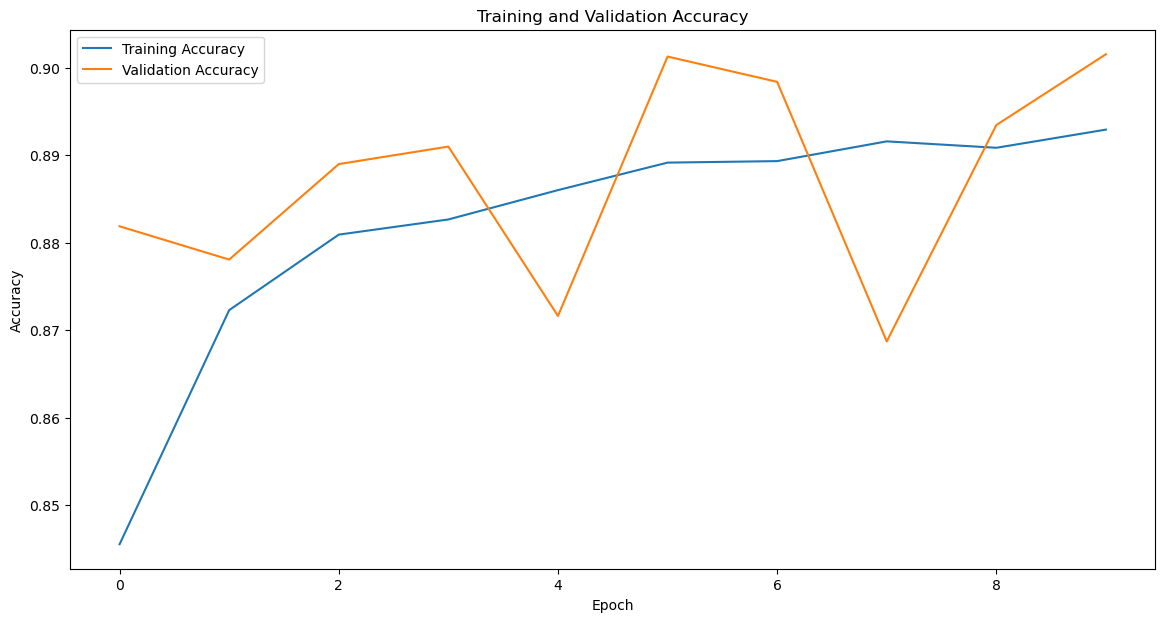

In [68]:
plot_training(history)

In [69]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))

1406/1406 [==============================] - 15s 11ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     20101
         1.0       0.91      0.91      0.91     24886

    accuracy                           0.90     44987
   macro avg       0.90      0.90      0.90     44987
weighted avg       0.90      0.90      0.90     44987

